## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

### This script contains the way to process image including normalization, gradient analysis, color segmentation, and edge detection ###

Input: image(.jpg)<br>
Output: dictionary (imgname:original img, segmented image,largest contour,area of the largest contour,mask used for segmentation)

import necessary libraries

In [33]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

Create functions that will be used in the analysis

In [34]:
%run functions.py

Get the path of the ISIC data and load pictures

In [35]:
image_path='/home/seo/jupyter/Capstone2/Data/Images/'
imagelist=os.listdir(image_path)
pics=[file for file in imagelist]

In [36]:
len(pics)

23906

In [37]:
imgname='ISIC_0030102.jpeg' # Pick a random picture for testing
filename=image_path+imgname

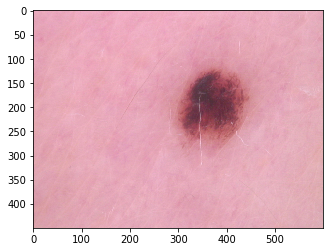

In [38]:
orig_img=cv2.imread(filename, cv2.IMREAD_COLOR)
orig_img = cv2.cvtColor(orig_img,cv2.COLOR_BGR2RGB)
img=orig_img
plt.imshow(img)

normalize image

In [39]:
norm_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

In [40]:
img=norm_image

split image into RGB channels

In [41]:
def split_into_rgb_channels(image):
    """Split the target image into its red, green and blue channels.image - a numpy array of shape (rows, columns, 3).
    output - three numpy arrays of shape (rows, columns) and dtype same as
    image, containing the corresponding channels.
    """
    red = image[:,:,2]
    green = image[:,:,1]
    blue = image[:,:,0]
    return red, green, blue

/home/seo/jupyter/Capstone2/Data/Images/ISIC_0030102.jpeg


(<matplotlib.axes._subplots.AxesSubplot at 0x7f55da3167f0>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 Text(0.5, 1.0, 'red'))

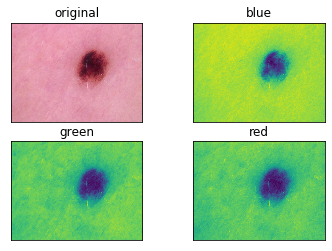

In [42]:
r,g,b=split_into_rgb_channels(img)
print(filename)
plt.subplot(2,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(2,2,2),plt.imshow(b),plt.xticks([]),plt.yticks([]),plt.title('blue')
plt.subplot(2,2,3),plt.imshow(g),plt.xticks([]),plt.yticks([]),plt.title('green')
plt.subplot(2,2,4),plt.imshow(r),plt.xticks([]),plt.yticks([]),plt.title('red')

reduce noise

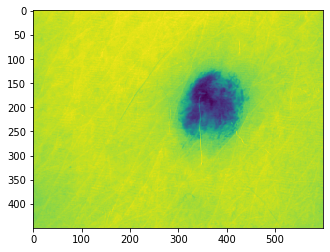

In [43]:
# Do some denoising on blue channel because that usually gives best contrast
gaussian = cv2.GaussianBlur(b,(3,3),0)
plt.imshow(gaussian)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f55da1ee908>,
 Text(0.5, 1.0, 'Before filter'),
 ([], <a list of 0 Text yticklabel objects>),
 ([], <a list of 0 Text xticklabel objects>))

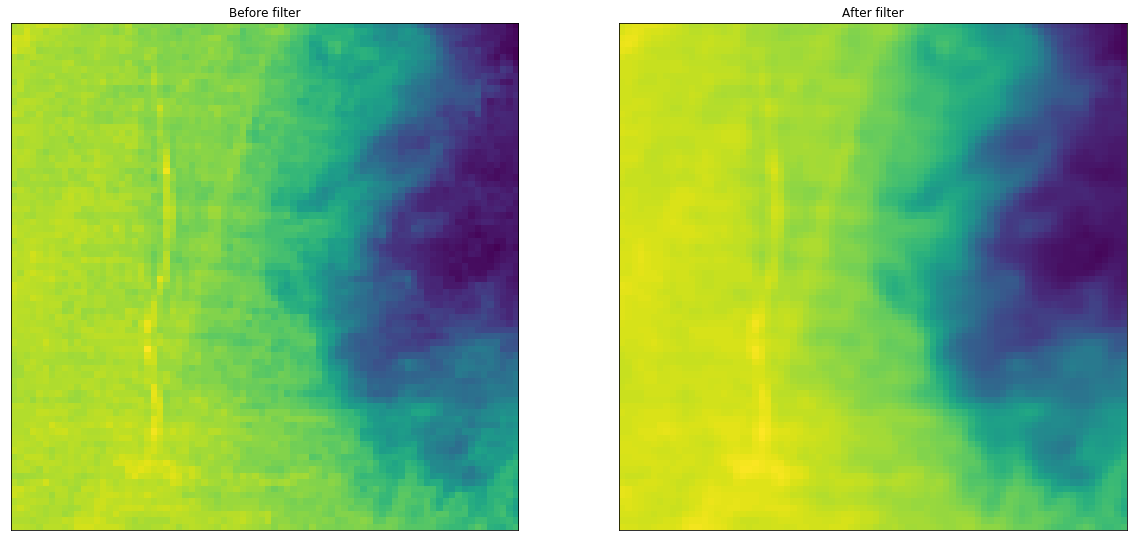

In [44]:
(h,w)=gaussian.shape[:2]
h=round(h/2)
w=round(w/2)
gaussian_crop = gaussian[h-40:h+40, w-40:w+40].copy()
b_crop = b[h-40:h+40, w-40:w+40].copy()
fig=plt.figure(figsize=(20,10))
fig.set_facecolor('white')
plt.subplot(1,2,2),plt.imshow(gaussian_crop),plt.title('After filter'),plt.yticks([]),plt.xticks([])
plt.subplot(1,2,1),plt.imshow(b_crop),plt.title('Before filter'),plt.yticks([]),plt.xticks([])

(0, 256)

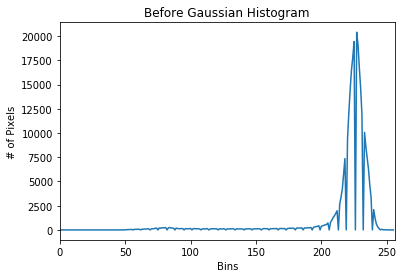

In [45]:
hist = cv2.calcHist([b], [0], None, [256], [0, 256])
plt.figure()
plt.title("Before Gaussian Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

(0, 256)

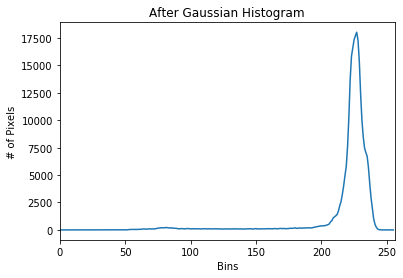

In [46]:
hist = cv2.calcHist([gaussian], [0], None, [256], [0, 256])
plt.figure()
plt.title("After Gaussian Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

As a result of applying gaussian filter, the color variance in the image smoothes out, meaning there are no more specks of different color in the lesion that may influence the threshold for border determination

(<matplotlib.axes._subplots.AxesSubplot at 0x7f55d9abb240>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 Text(0.5, 1.0, 'gaussian'))

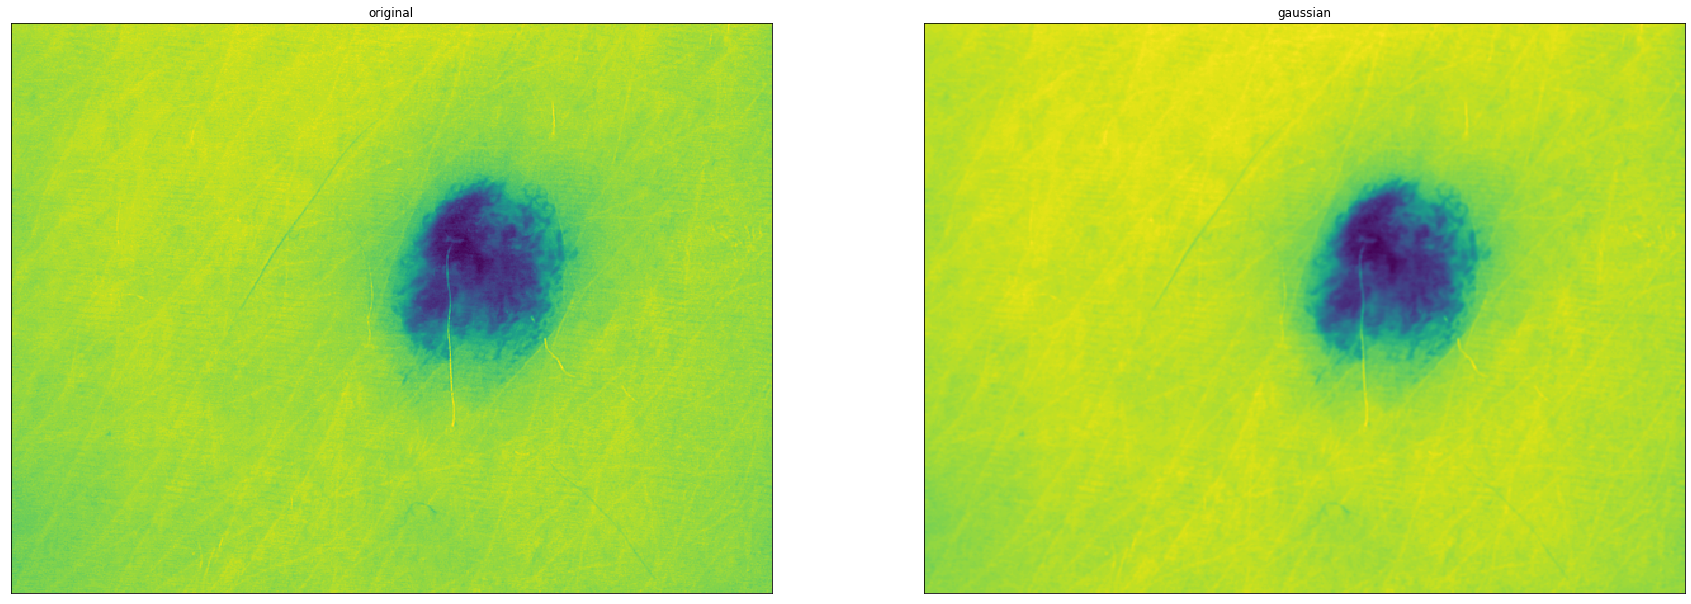

In [47]:
plt.figure(figsize = (30,20))
plt.subplot(1,2,1),plt.imshow(b),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(1,2,2),plt.imshow(gaussian),plt.xticks([]),plt.yticks([]),plt.title('gaussian')

find edge & image segmentation

(<matplotlib.axes._subplots.AxesSubplot at 0x7f55d9976550>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 Text(0.5, 1.0, 'only roi'))

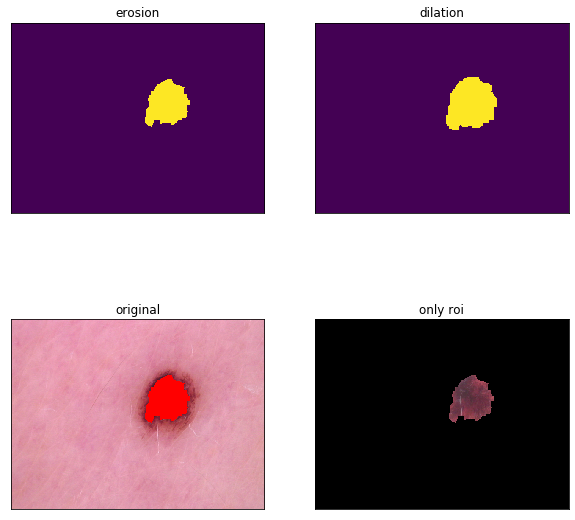

In [48]:
import cv2
import numpy as np
fig,ax =plt.subplots(figsize = (10,10))

kernel = np.ones((5,5),np.uint8)
th, threshed = cv2.threshold(gaussian, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
erosion = cv2.erode(threshed,kernel,iterations = 3)
dilation = cv2.dilate(erosion,kernel,iterations = 3)
plt.subplot(2,2,1),plt.imshow(erosion),plt.xticks([]),plt.yticks([]),plt.title('erosion')
plt.subplot(2,2,2),plt.imshow(dilation),plt.xticks([]),plt.yticks([]),plt.title('dilation')

## Find the first contour that greate than 100, locate in centeral region
## Adjust the parameter when necessary
cnts, hierarchy=cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
cnts = sorted(cnts, key=cv2.contourArea)
H,W = img.shape[:2]
maxContour = 0


for contour in cnts:
    cv2.drawContours(img,contour,-1,(255,0,0),-1)
    contourSize = cv2.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
    #if contour
cv2.drawContours(img,[contour],-1,(255,0,0),-1)
## Create mask and do bitwise-op
mask = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(mask, [contour],-1, 255, -1)
#area = cv2.contourArea(contour)
dst = cv2.bitwise_and(orig_img, orig_img, mask=mask)
plt.subplot(2,2,3),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(2,2,4),plt.imshow(dst),plt.xticks([]),plt.yticks([]),plt.title('only roi')

Check if there are contour that has a flat line that covers more than half the size of the entire image. This is unlikely to be the lesion and therefore needs to be removed

In [49]:
orig_cnts=cnts
new_cnts=list()
for con in range(len(cnts)):
    contour=cnts[con]
    bunch=[tuple(contour[num][0]) for num in range(len(contour))]
    y_min=min(bunch, key=lambda t: t[0])[0]
    y_max=max(bunch, key=lambda t: t[0])[0]
    x_min=min(bunch, key=lambda t: t[1])[1]
    x_max=max(bunch, key=lambda t: t[1])[1]
    
    y_count=0
    x_count=0

    for num in bunch:
        if num[0]==x_min:
            x_count=x_count+1
        if num[0]==x_max:
            x_count=x_count+1
        if num[1]==y_min:
            y_count=y_count+1
        if num[1]==y_max:
            y_count=y_count+1
    if (x_count>round(img.shape[:2][0]*0.6)) or (y_count>round(img.shape[:2][1]*0.6)):
        #new_cnts.append(cnts[con])
        cnts.pop(con)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f55d9a07b70>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 Text(0.5, 1.0, 'only roi'))

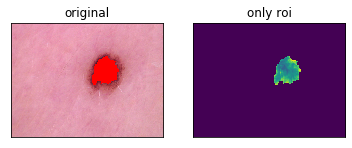

In [50]:
#retread to check if there are removed contour
for contour in cnts:
    cv2.drawContours(img,contour,-1,(255,0,0),-1)
    contourSize = cv2.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
    #if contour
cv2.drawContours(img,[contour],-1,(255,0,0),-1)
## Create mask and do bitwise-op
mask = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(mask, [contour],-1, 255, -1)
#area = cv2.contourArea(contour)
dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
plt.subplot(1,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(1,2,2),plt.imshow(dst),plt.xticks([]),plt.yticks([]),plt.title('only roi')

In [51]:
img_dict={imgname:[orig_img,dst,maxContourData,maxContour,mask]}

In [52]:
import pickle
pickle.dump(img_dict,open('testimage',"wb"))